In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.handlers import condition , seed , trace

from einops import rearrange

import optax
from tqdm import tqdm

import blackjax
from functools import partial

import warnings
warnings.filterwarnings('ignore')

import jax_galsim as galsim
import galsim as gs

/Users/ec270266/anaconda3/envs/shearest/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
params_dir = '../data/trecs_gal_params.npy'

def clip_by_l2_norm(x):
    norm = jnp.linalg.norm(x, axis=0)
    scale = jnp.minimum(1.0, 1. / (norm + 1e-2))  # adding epsilon for numerical stability and enforcing norm < 1.
    return x * scale

def complex_2_stack(x):
    """Convert a complex image to a stack of real and imaginary parts."""
    return jnp.stack([jnp.real(x), jnp.imag(x)], axis=0)

def stack_2_complex(x, batch=None):
    """Convert a stack of real and imaginary parts to a complex image."""
    if batch is None:
        return jnp.complex64(x[0] + 1j * x[1])
    else:
        return jnp.complex64(x[:,0] + 1j * x[:,1])

In [3]:
catalog = gs.COSMOSCatalog(dir='/Users/ec270266/Documents/Phd/Argos/Datasets/COSMOS_25.2_training_sample')

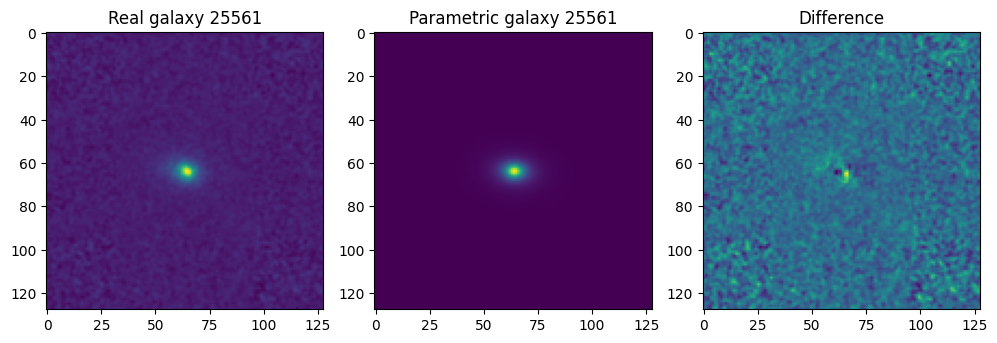

In [71]:
Npx = 128
pixel_scale_hst = 0.03
flux = 1.
gal_ind = np.random.randint(0, 81498)
gal_real = catalog.makeGalaxy(gal_ind)
gal_param = catalog.makeGalaxy(gal_ind, gal_type='parametric')

psf = gal_real.original_psf

gal_real =  gs.Convolve([gal_real, psf])
gal_param = gs.Convolve([gal_param, psf])

gal_real = gal_real.withFlux(flux)
gal_param = gal_param.withFlux(flux)

# shear the parametric galaxy
g1, g2 = 0.05, -0.05
gal_param = gal_param.shear(g1=g1, g2=g2)

gal_im_real = gal_real.drawImage(nx=Npx, ny=Npx, scale=pixel_scale_hst)
gal_im_param = gal_param.drawImage(nx=Npx, ny=Npx, scale=pixel_scale_hst)

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(gal_im_real.array)
ax[0].set_title(f'Real galaxy {gal_ind}')
ax[1].imshow(gal_im_param.array)
ax[1].set_title(f'Parametric galaxy {gal_ind}')
ax[2].imshow(gal_im_real.array - gal_im_param.array)
ax[2].set_title('Difference')
plt.tight_layout()
plt.show()

In [35]:
# Dine simulation parameters
Ngal = 100
Npx = 128
pixel_scale = 0.15 # in arcsec/pixel
fov_size = Npx * pixel_scale / 3600 # in degrees
noise_uv = .004
# noise = 1e-5
g1_true = -0.05
g2_true = 0.05

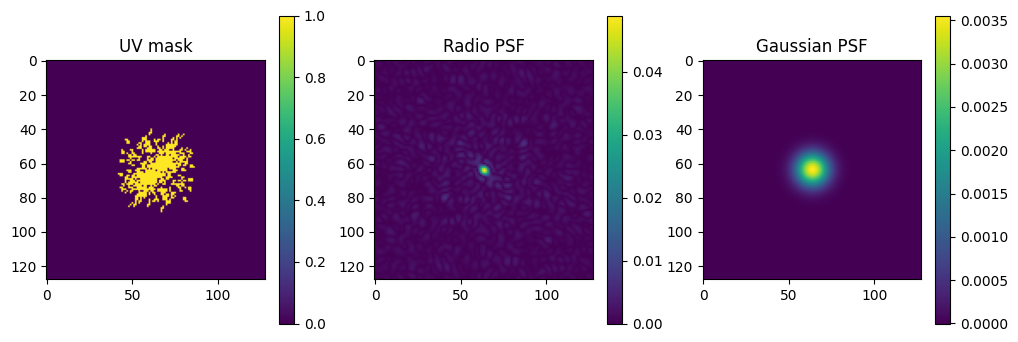

In [72]:
# Radio PSF
import argosim
import argosim.antenna_utils
import argosim.imaging_utils
# antenna = argosim.antenna_utils.y_antenna_arr(n_antenna=6, r=1e3)
# antenna = argosim.antenna_utils.random_antenna_arr(n_antenna=80, E_lim=50e3, N_lim=50e3)
# antenna = argosim.antenna_utils.uni_antenna_array(n_antenna_E=10, n_antenna_N=4, E_lim=1e3, N_lim=3e3)
antenna = argosim.antenna_utils.random_antenna_arr(n_antenna=15, E_lim=50e3, N_lim=50e3, seed=33)
b_enu = argosim.antenna_utils.get_baselines(antenna)
track, _ = argosim.antenna_utils.uv_track_multiband(b_ENU=b_enu, track_time=10, n_times=4, f=1.4e9, df=1e8, n_freqs=4)
mask, _ = argosim.imaging_utils.grid_uv_samples(track, sky_uv_shape=(Npx, Npx), fov_size=(fov_size, fov_size))
# mask = np.ones_like(mask)
uv_pos = np.where(np.abs(mask) > 0.)

plt.subplots(1,3, figsize=(12, 4))
plt.subplot(131)
plt.imshow(np.real(mask))
plt.title('UV mask')
plt.colorbar()
plt.subplot(132)
plt.imshow(np.abs(argosim.imaging_utils.uv2sky(mask)))
plt.title('Radio PSF')
plt.colorbar()
plt.subplot(133)
plt.imshow(galsim.Gaussian(flux=1., sigma=.2).drawImage(nx=Npx, ny=Npx, scale=pixel_scale).array)
plt.title('Gaussian PSF')
plt.colorbar()
# plt.savefig("../outputs/test_radio_psf.pdf")
plt.show()

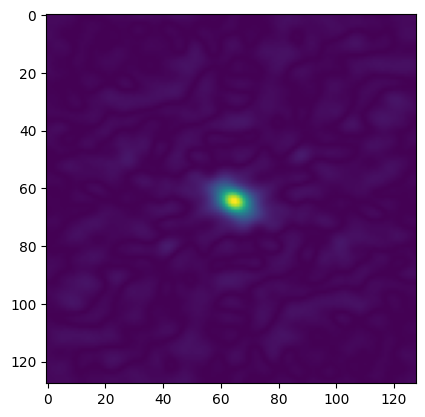

In [73]:
Npx = 128
pixel_scale = 0.03 # hst pixel scale
flux = 1.
# gal_ind = np.random.randint(0, 81498)
gal_real = catalog.makeGalaxy(gal_ind)
gal_param = catalog.makeGalaxy(gal_ind, gal_type='parametric')

psf = gal_real.original_psf

gal_real =  gs.Convolve([gal_real, psf])
gal_param = gs.Convolve([gal_param, psf])

gal_real = gal_real.withFlux(flux)
gal_param = gal_param.withFlux(flux)

# shear the parametric galaxy
g1, g2 = 0.05, -0.05
gal_param = gal_param.shear(g1=g1, g2=g2)

gal_kimage = gal_param.drawKImage(nx=Npx, ny=Npx, scale=2*np.pi/pixel_scale/Npx)

gal_kimage = gal_kimage.array

vis = gal_kimage[uv_pos]

img_aux = np.zeros_like(mask)
img_aux[uv_pos] = vis

# plt.imshow(np.abs(img_aux))

plt.imshow(np.abs(np.fft.ifftshift(np.fft.ifft2(img_aux))))


In [ ]:
def draw_exp_profile(hlr, flux, e1, e2, g1, g2, uv_pos, Npx, pixel_scale):#, sigma_noise_uv=1e-3):
    gal = galsim.Exponential(half_light_radius=hlr, flux=flux)
    
    # intrinsic ellipticity
    gal = gal.shear(e1=e1, e2=e2)

    # cosmic shear
    gal = gal.shear(g1=g1,g2=g2)

     # Convert to Fourier space
    gal_kimage = gal.drawKImage(nx=Npx, ny=Npx, scale=pixel_scale)
    
    # Add noise
    gal_kimage = gal_kimage.array #+ np.random.normal(0, sigma_noise_uv, gal_kimage.array.shape) + 1j * np.random.normal(0, sigma_noise_uv, gal_kimage.array.shape)

    # # Apply the PSF mask in Fourier space
    # gal_kobs = gal_kimage * mask

    # Sample the visibilities
    vis = gal_kimage[uv_pos]

    # Convert back to image space
    # gal_obs = jnp.fft.ifftshift(jnp.fft.ifft2(gal_kobs))
    
    # return jnp.abs(gal_obs)
    return complex_2_stack(vis)

In [ ]:
def draw_cosmos_profile(catalog, idx, flux, g1, g2, uv_pos, Npx, pixel_scale):#, sigma_noise_uv=1e-3):
    gal_real = catalog.makeGalaxy(idx)
    psf = gal_real.original_psf
    gal_param = catalog.makeGalaxy(idx, gal_type='parametric')
    gal_param = gs.Convolve([gal_param, psf])

    # set the flux
    gal_param = gal_param.withFlux(flux)

    # cosmic shear
    gal_param = gal_param.shear(g1=g1, g2=g2)

     # Convert to Fourier space
    gal_kimage = gal_param.drawKImage(nx=Npx, ny=Npx, scale=pixel_scale)
    
    # Add noise
    gal_kimage = gal_kimage.array #+ np.random.normal(0, sigma_noise_uv, gal_kimage.array.shape) + 1j * np.random.normal(0, sigma_noise_uv, gal_kimage.array.shape)

    # # Apply the PSF mask in Fourier space
    # gal_kobs = gal_kimage * mask

    # Sample the visibilities
    vis = gal_kimage[uv_pos]

    # Convert back to image space
    # gal_obs = jnp.fft.ifftshift(jnp.fft.ifft2(gal_kobs))
    
    # return jnp.abs(gal_obs)
    return complex_2_stack(vis)

In [ ]:
ell_prior_scale = 0.5
g_prior_scale = 0.3
#@partial(jax.jit, static_argnums=(0,1,2,3,4))
def model_fn(Ngal=10, Npx=128, pixel_scale=0.15, uv_pos=None, noise_uv=1e-2, obs=None, params_dir=params_dir, catalog=None):

    # define parameters and their prior
    params = np.load(params_dir, allow_pickle=True)[()]
    # pixel_scale = params['pixelscale']
    # Npx = params['Npix']

    u = jnp.ones((Ngal,)) # sampling galaxies all at once

    hlr_fit = params['beta_fit_hlr']
    hlr = numpyro.sample("hlr", dist.Beta(hlr_fit['a'], hlr_fit['b']), sample_shape=(Ngal,)) * hlr_fit['scale'] + hlr_fit['loc']
    # hlr = jnp.abs((numpyro.sample("hlr", dist.Normal(0.*u, 1.*u)) + 4.) * 1.) + 1e-3
    
    flux_fit = params['beta_fit_flux']
    flux = numpyro.sample("flux", dist.Beta(flux_fit['a'], flux_fit['b']), sample_shape=(Ngal,)) * flux_fit['scale'] + flux_fit['loc']
    # flux = jnp.abs((numpyro.sample("flux", dist.Normal(0.*u, 1.*u)) + 10.) * 2.) + 1e-3
    
    # r_ell_fit = params['beta_fit_r_ell']
    # r_ell = numpyro.sample("r_ell", dist.Beta(r_ell_fit['a'], r_ell_fit['b']), sample_shape=(Ngal,)) * r_ell_fit['scale'] + r_ell_fit['loc']
    # angle_ell = numpyro.sample("angle_ell", dist.Uniform(-jnp.pi, jnp.pi), sample_shape=(Ngal,))

    # e1 = r_ell * jnp.cos(angle_ell)
    # e2 = r_ell * jnp.sin(angle_ell)
    e1 = numpyro.sample("e1", dist.Normal(0.*u, ell_prior_scale*u))/ell_prior_scale * .2
    e2 = numpyro.sample("e2", dist.Normal(0.*u, ell_prior_scale*u))/ell_prior_scale * .2


    # assuming constant shear across galaxies
    g1 = numpyro.sample("g1", dist.Normal(jnp.zeros((1,)), g_prior_scale*jnp.ones((1,))))/g_prior_scale*.1
    g2 = numpyro.sample("g2", dist.Normal(jnp.zeros((1,)), g_prior_scale*jnp.ones((1,))))/g_prior_scale*.1

    # clipping undefined e and g values
    e = jnp.stack([e1, e2], 0)
    e = clip_by_l2_norm(e)

    g = jnp.repeat(jnp.stack([g1, g2], 0), Ngal, -1)
    g = clip_by_l2_norm(g)

    # generate galaxy image
    if catalog is None:
        draw = partial(draw_exp_profile, uv_pos=uv_pos, Npx=Npx, pixel_scale=pixel_scale)
        im_gal = jax.vmap(draw)(hlr=hlr,
                            flux=flux, 
                            e1=e[0], 
                            e2=e[1],
                            g1=g[0], 
                            g2=g[1],)
    else:
        idx = np.random.randint(0, catalog.nobjects, (Ngal,))
        draw = partial(draw_cosmos_profile, uv_pos=uv_pos, Npx=Npx, pixel_scale=pixel_scale catalog=catalog)
    
    # add Gaussian noise
    if obs is None:
        return numpyro.sample("obs", dist.Normal(im_gal, noise_uv))
    else:
        return numpyro.sample("obs", dist.Normal(im_gal, noise_uv), obs=data)



In [9]:
# Generate observations
key = jax.random.PRNGKey(42)
model = partial(model_fn, Ngal=Ngal, Npx=Npx, pixel_scale=pixel_scale,  uv_pos=uv_pos, noise_uv=noise_uv) 
seeded_model = seed(model, key)

# Conditioning model to generate observation with [g1, g2]
conditionned_model = condition(seeded_model, {"g1":g1_true*jnp.ones((1,))/.1, "g2":g2_true*jnp.ones((1,))/.1})
data = conditionned_model()

Data shape: (1280, 1280)
Data max: 0.25327348469046607


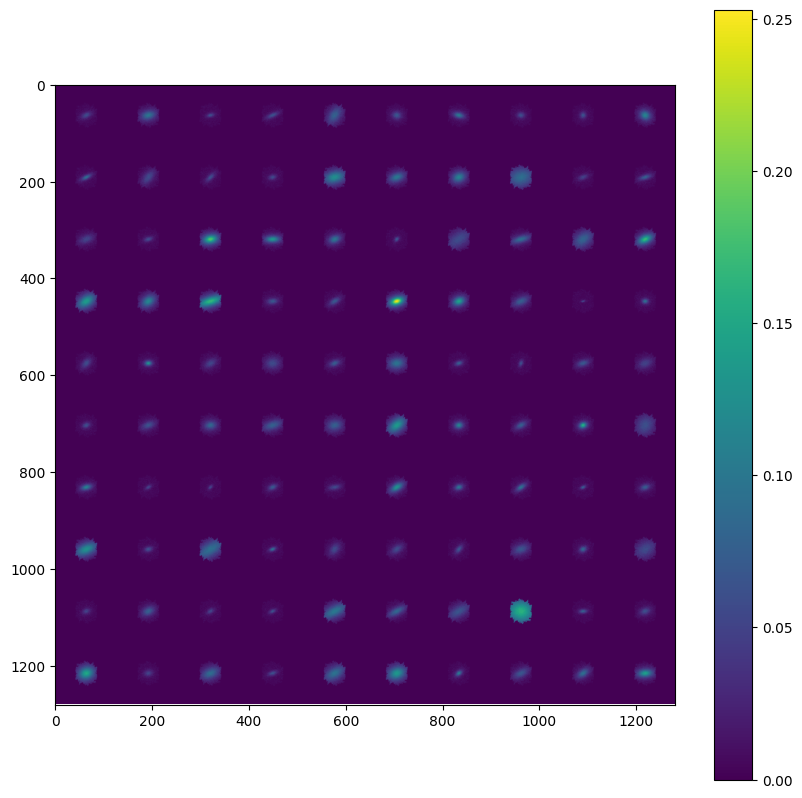

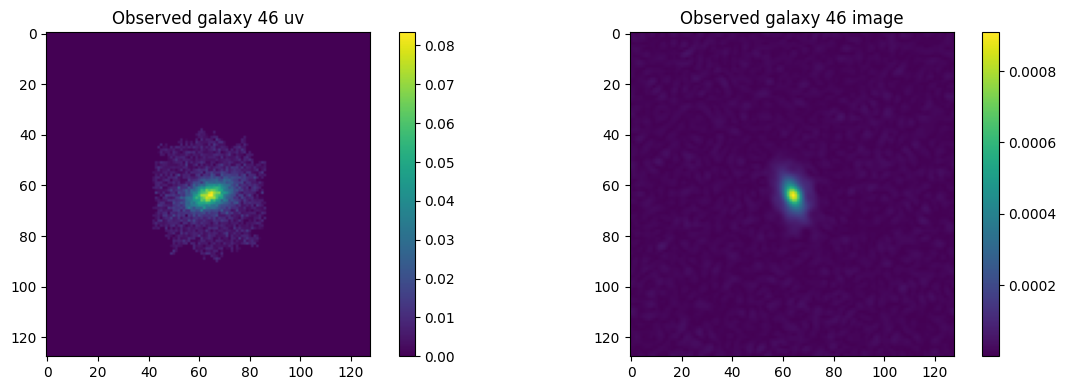

In [10]:
# Plot observations
# data_complex = stack_2_complex(data, batch=True)
data_complex = []
for vis in stack_2_complex(data, batch=True):
    img_aux = np.zeros_like(mask)
    img_aux[uv_pos] = vis
    data_complex.append(img_aux)
data_ = rearrange(data_complex, "(n1 n2) h w -> (n1 h) (n2 w)", n1=10, n2=10)
# data_ = rearrange(data_complex, "(n1 n2) h w -> (n1 h) (n2 w)", n1=10, n2=10)
plt.figure(figsize=(10,10))
plt.imshow(np.abs(data_), vmin=np.min(np.abs(data_)), vmax=np.max(np.abs(data_)))
print('Data shape:', data_.shape)
print('Data max:', np.max(np.abs(data_)))
# print(f'Data max: {np.max(np.abs(data_))}', file=log_file)
plt.colorbar()
# plt.savefig("../outputs/test_radio_data.pdf")
plt.show()

# Plot a random galaxy
plt.subplots(1,2,figsize=(12,4))
plt.subplot(121)
idx = np.random.randint(0, Ngal)
plt.imshow(np.abs(data_complex[idx]))
plt.title(f"Observed galaxy {idx} uv")
plt.colorbar()
plt.subplot(122)
plt.imshow(np.abs(np.fft.ifftshift(np.fft.ifft2(data_complex[idx]))))
plt.title(f"Observed galaxy {idx} image")
plt.colorbar()
plt.tight_layout()
# plt.savefig("../outputs/test_radio_data_galaxy.pdf")
plt.show()